In [15]:
import os
import json
from pprint import pprint
import requests
import pandas as pd
import time
from config import api_key, g_key, second_key
import gmaps


In [8]:
#Read in procurement data
filepath = os.path.join("Top_100_Contractors_Report_Fiscal_Year_2019.xls")

In [9]:
procurement_data = pd.read_excel(filepath, sheet_name = None)

In [10]:
print(procurement_data)

{'Federal':                         Global Vendor Name  Number of Actions  \
0              LOCKHEED MARTIN CORPORATION              58430   
1                      BOEING COMPANY, THE              18765   
2             GENERAL DYNAMICS CORPORATION              17136   
3                         RAYTHEON COMPANY              12662   
4             NORTHROP GRUMMAN CORPORATION              12984   
..                                     ...                ...   
95                    GOVERNMENT OF CANADA               2143   
96                    GEO GROUP, INC., THE                379   
97               INSIGHT ENTERPRISES  INC.               1231   
98         UNITEDHEALTH GROUP INCORPORATED                293   
99  WORLD WIDE TECHNOLOGY HOLDING CO., LLC               1842   

    Dollars Obligated  %Total Actions  %Total Dollars  
0        4.866580e+10        0.000777        0.082314  
1        2.808870e+10        0.000250        0.047510  
2        2.096105e+10        0.000228  

In [171]:
#Isolating Spreadsheet for analysis
federal_vendor_names = procurement_data["Federal"][["Global Vendor Name","Number of Actions", "Dollars Obligated"]]
federal_vendor_names = federal_vendor_names.rename({"Global Vendor Name": "Business Name"}, axis = 1)
federal_vendor_names

,Business Name,Number of Actions,Dollars Obligated
0,LOCKHEED MARTIN CORPORATION,58430,4.866580e+10
1,"BOEING COMPANY, THE",18765,2.808870e+10
2,GENERAL DYNAMICS CORPORATION,17136,2.096105e+10
3,RAYTHEON COMPANY,12662,1.635078e+10
4,NORTHROP GRUMMAN CORPORATION,12984,1.610125e+10
...,...,...,...
95,GOVERNMENT OF CANADA,2143,6.115669e+08
96,"GEO GROUP, INC., THE",379,6.073432e+08
97,INSIGHT ENTERPRISES INC.,1231,5.870121e+08
98,UNITEDHEALTH GROUP INCORPORATED,293,5.739703e+08


In [172]:
#adding average action cost
federal_vendor_names["Per Capita Spending"] = federal_vendor_names["Dollars Obligated"]/federal_vendor_names["Number of Actions"]
federal_vendor_names

,Business Name,Number of Actions,Dollars Obligated,Per Capita Spending
0,LOCKHEED MARTIN CORPORATION,58430,4.866580e+10,8.328906e+05
1,"BOEING COMPANY, THE",18765,2.808870e+10,1.496867e+06
2,GENERAL DYNAMICS CORPORATION,17136,2.096105e+10,1.223217e+06
3,RAYTHEON COMPANY,12662,1.635078e+10,1.291327e+06
4,NORTHROP GRUMMAN CORPORATION,12984,1.610125e+10,1.240084e+06
...,...,...,...,...
95,GOVERNMENT OF CANADA,2143,6.115669e+08,2.853789e+05
96,"GEO GROUP, INC., THE",379,6.073432e+08,1.602489e+06
97,INSIGHT ENTERPRISES INC.,1231,5.870121e+08,4.768579e+05
98,UNITEDHEALTH GROUP INCORPORATED,293,5.739703e+08,1.958943e+06


In [173]:
#creating bin ranges for number of actions
bins = [0, 999, 9999, 99999, 999999, 1999999, 5000000]
group_names = ["Under 1,000", "1,000-9,999", "10,000-99,999", "100,000-999,999", "1,000,000-1,999,999", "2,000,000+"]

In [174]:
#slicing data into bins 
federal_vendor_names["Range of Actions"] = pd.cut(federal_vendor_names["Number of Actions"], bins, labels=group_names, include_lowest=True)
federal_vendor_names

,Business Name,Number of Actions,Dollars Obligated,Per Capita Spending,Range of Actions
0,LOCKHEED MARTIN CORPORATION,58430,4.866580e+10,8.328906e+05,"10,000-99,999"
1,"BOEING COMPANY, THE",18765,2.808870e+10,1.496867e+06,"10,000-99,999"
2,GENERAL DYNAMICS CORPORATION,17136,2.096105e+10,1.223217e+06,"10,000-99,999"
3,RAYTHEON COMPANY,12662,1.635078e+10,1.291327e+06,"10,000-99,999"
4,NORTHROP GRUMMAN CORPORATION,12984,1.610125e+10,1.240084e+06,"10,000-99,999"
...,...,...,...,...,...
95,GOVERNMENT OF CANADA,2143,6.115669e+08,2.853789e+05,"1,000-9,999"
96,"GEO GROUP, INC., THE",379,6.073432e+08,1.602489e+06,"Under 1,000"
97,INSIGHT ENTERPRISES INC.,1231,5.870121e+08,4.768579e+05,"1,000-9,999"
98,UNITEDHEALTH GROUP INCORPORATED,293,5.739703e+08,1.958943e+06,"Under 1,000"


In [186]:
#creating bar chart to show number of actions
range_revenue = federal_vendor_names.groupby("Range of Actions")
range_count = range_revenue["Business Name"].count()
range_count

Range of Actions
Under 1,000            46
1,000-9,999            35
10,000-99,999          13
100,000-999,999         4
1,000,000-1,999,999     1
2,000,000+              0
Name: Business Name, dtype: int64

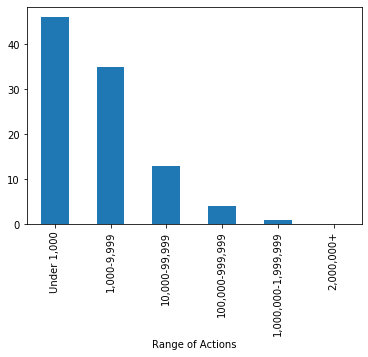

In [187]:
range_count.plot(kind = "bar")

In [6]:
#creating ORIGINAL SAM API for loop to find information regarding procurement companies
url = "https://api.data.gov/sam/v3/registrations?qterms="

businesses = federal_vendor_names["Business Name"]
bus_name = []
address_line_one = []
address_city = []
state = []
zip_code = []
country = []                                    
duns = []
plus_four = []
not_found = []
i = 0

for business in businesses:
    query_url = f"{url}{business[0:6]}&length=500&api_key={api_key}"
    response = requests.get(query_url).json()
    i = i+1
    print(f"I'm looking for {business}, number {i} of 100")
    time.sleep(1)
    for result in response["results"]:
        if business == result["legalBusinessName"].upper():
            bus_name.append(result["legalBusinessName"].upper())
            address_line_one.append(result["samAddress"]["line1"])
            address_city.append(result["samAddress"]["city"])
            state.append(result["samAddress"]["stateOrProvince"])
            zip_code.append(result["samAddress"]["zip"])
            country.append(result["samAddress"]["countryCode"])
            duns.append(result["duns"])
            plus_four.append(result["duns_plus4"])
            print(f"I've added information for request: {business}")
            break



I'm looking for LOCKHEED MARTIN CORPORATION, number 1 of 100
I've added information for request: LOCKHEED MARTIN CORPORATION
I'm looking for BOEING COMPANY, THE, number 2 of 100
I've added information for request: BOEING COMPANY, THE
I'm looking for GENERAL DYNAMICS CORPORATION, number 3 of 100
I'm looking for RAYTHEON COMPANY, number 4 of 100
I've added information for request: RAYTHEON COMPANY
I'm looking for NORTHROP GRUMMAN CORPORATION, number 5 of 100
I've added information for request: NORTHROP GRUMMAN CORPORATION
I'm looking for MCKESSON CORPORATION, number 6 of 100
I've added information for request: MCKESSON CORPORATION
I'm looking for UNITED TECHNOLOGIES CORPORATION, number 7 of 100
I'm looking for HUNTINGTON INGALLS INDUSTRIES, INC., number 8 of 100
I'm looking for LEIDOS HOLDINGS, INC., number 9 of 100
I've added information for request: LEIDOS HOLDINGS, INC.
I'm looking for L3HARRIS TECHNOLOGIES, INC., number 10 of 100
I've added information for request: L3HARRIS TECHNOLOG

In [84]:
#updated api loop with Beta site
    
businesses = federal_vendor_names["Business Name"]
bus_name = []
address_line_one = []
address_city = []
state = []
zip_code = []
country = []                                    
duns = []
plus_four = []
i = 0

for business in businesses:
    if business not in bus_name and len(business.split(" ")) > 1:
        business_search = business.split(" ")[0]+" "+business.split(" ")[1]+" "+business.split(" ")[2].title()
        url_beta = f"https://api.sam.gov/entity-information/v1/entities?api_key={second_key}&dbaName={business_search}"
        response = requests.get(url_beta).json()
        i = i+1
        print(f"I'm looking for {business}, number {i} of 100")
        time.sleep(1)
        for result in response["entityData"]:
            if business == result["entityRegistration"]["legalBusinessName"].upper():
                bus_name.append(result["entityRegistration"]["legalBusinessName"].upper())
                address_line_one.append(result["coreData"]["physicalAddress"]["addressLine1"])
                address_city.append(result["coreData"]["physicalAddress"]["city"])
                state.append(result["coreData"]["physicalAddress"]["stateOrProvinceCode"])
                zip_code.append(result["coreData"]["physicalAddress"]["zipCode"])
                country.append(result["coreData"]["physicalAddress"]["countryCode"])
                print(f"I've added information for request: {business}")
                break


I'm looking for CARAHSOFT TECHNOLOGY CORPORATION, number 1 of 100
I'm looking for SERCO GROUP PLC, number 2 of 100
I'm looking for PATRIOT TEAM, number 3 of 100
I'm looking for CERNER GOVERNMENT SERVICES  INC., number 4 of 100
I'm looking for HENSEL PHELPS CONSTRUCTION CO, number 5 of 100
I'm looking for EMERGENT BIOSOLUTIONS INC., number 6 of 100
I'm looking for NANA REGIONAL CORPORATION, INC., number 7 of 100
I'm looking for CONSORTIUM MANAGEMENT GROUP  INC., number 8 of 100
I'm looking for ROYAL DUTCH SHELL PLC, number 9 of 100
I'm looking for CARDINAL HEALTH  INC., number 10 of 100
I'm looking for BP P.L.C., number 11 of 100
I'm looking for UNISYS CORPORATION, number 12 of 100
I'm looking for CROWLEY HOLDINGS  INC, number 13 of 100
I'm looking for SECURITAS CRITICAL INFRASTRUCTURE SERVICES  INC., number 14 of 100
I'm looking for BROOKHAVEN SCIENCE ASSOCIATES LLC, number 15 of 100
I'm looking for GREAT LAKES DREDGE & DOCK CORPORATION, number 16 of 100
I'm looking for GOVERNMENT OF C

In [200]:
#Finding Business Dad using Legal Business Name search (total match)
businesses = federal_vendor_names["Business Name"]

for business in businesses[95:100]:
    if business not in bus_name:
        business_search = business.title()
        url_beta = f"https://api.sam.gov/entity-information/v1/entities?api_key={second_key}&legalBusinessName={business_search}"
        response = requests.get(url_beta).json()
        print(f"I'm looking for {business}")
        time.sleep(1)
        for result in response["entityData"]:
            if business == result["entityRegistration"]["legalBusinessName"].upper():
                bus_name.append(result["entityRegistration"]["legalBusinessName"].upper())
                address_line_one.append(result["coreData"]["physicalAddress"]["addressLine1"])
                address_city.append(result["coreData"]["physicalAddress"]["city"])
                state.append(result["coreData"]["physicalAddress"]["stateOrProvinceCode"])
                zip_code.append(result["coreData"]["physicalAddress"]["zipCode"])
                country.append(result["coreData"]["physicalAddress"]["countryCode"])
                reg_date.append(result["entityRegistration"]["registrationDate"])
                congressional_dis.append(result["coreData"]["congressionalDistrict"])
                print(f"I've added information for request: {business}")
                break

I'm looking for GOVERNMENT OF CANADA
I've added information for request: GOVERNMENT OF CANADA
I'm looking for GEO GROUP, INC., THE
I've added information for request: GEO GROUP, INC., THE
I'm looking for INSIGHT ENTERPRISES  INC.
I'm looking for UNITEDHEALTH GROUP INCORPORATED
I'm looking for WORLD WIDE TECHNOLOGY HOLDING CO., LLC


In [216]:
#Finding Business Dad using Legal Business Name search (first word match)

businesses = federal_vendor_names["Business Name"]

for business in businesses[96:100]:
    if business not in bus_name:
        business_search = business.split(" ")[0].title()
        business_search = business_search.title()
        url_beta = f"https://api.sam.gov/entity-information/v1/entities?api_key={second_key}&legalBusinessName={business_search}"
        response = requests.get(url_beta).json()
        print(f"I'm looking for {business}")
        time.sleep(1)
        for result in response["entityData"]:
            if business == result["entityRegistration"]["legalBusinessName"].upper():
                bus_name.append(result["entityRegistration"]["legalBusinessName"].upper())
                address_line_one.append(result["coreData"]["physicalAddress"]["addressLine1"])
                address_city.append(result["coreData"]["physicalAddress"]["city"])
                state.append(result["coreData"]["physicalAddress"]["stateOrProvinceCode"])
                zip_code.append(result["coreData"]["physicalAddress"]["zipCode"])
                country.append(result["coreData"]["physicalAddress"]["countryCode"])
                reg_date.append(result["entityRegistration"]["registrationDate"])
                congressional_dis.append(result["coreData"]["congressionalDistrict"])
                print(f"I've added information for request: {business}")
                break

I'm looking for INSIGHT ENTERPRISES  INC.


KeyError: 'entityData'

In [219]:
print(len(bus_name))
print(len(address_line_one))
print(len(address_city))
print(len(state))
print(len(zip_code))
print(len(country))


43
43
43
43
43
43


In [220]:
#creating dataframe of results
federal_spending = pd.DataFrame({"Business Name":bus_name, "Address": address_line_one, "City": address_city, "State":state, "Zip":zip_code, "Country": country})
federal_spending = pd.merge(federal_spending, federal_vendor_names, on = "Business Name", how = "left")
federal_spending["Lat"] = ""
federal_spending["Lon"] = ""

federal_spending

,Business Name,Address,City,State,Zip,Country,Number of Actions,Dollars Obligated,Per Capita Spending,Range of Actions,Lat,Lon
0,LOCKHEED MARTIN CORPORATION,700 N FREDERICK AVE,GAITHERSBURG,MD,20879,USA,58430,4.866580e+10,8.328906e+05,"10,000-99,999",,
1,"BOEING COMPANY, THE",3373 BRECKINRIDGE BLVD,RICHARDSON,TX,75082,USA,18765,2.808870e+10,1.496867e+06,"10,000-99,999",,
2,RAYTHEON COMPANY,5001 US HIGHWAY 30 W,FORT WAYNE,IN,46818,USA,12662,1.635078e+10,1.291327e+06,"10,000-99,999",,
3,MCKESSON CORPORATION,6555 STATE HIGHWAY 161,IRVING,TX,75039,USA,82167,9.640425e+09,1.173272e+05,"10,000-99,999",,
4,"LEIDOS HOLDINGS, INC.",1750 PRESIDENTS ST,RESTON,VA,20190,USA,4830,7.272381e+09,1.505669e+06,"1,000-9,999",,
5,FLUOR CORPORATION,6700 LAS COLINAS BLVD,IRVING,TX,75039,USA,364,5.254247e+09,1.443474e+07,"Under 1,000",,
6,BOOZ ALLEN HAMILTON HOLDING CORPORATION,8283 GREENSBORO DR,MCLEAN,VA,22102,USA,5731,5.146754e+09,8.980551e+05,"1,000-9,999",,
7,JACOBS ENGINEERING GROUP INC.,200 W FORSYTH ST STE 1520,JACKSONVILLE,FL,32202,USA,3630,3.345955e+09,9.217506e+05,"1,000-9,999",,
8,OSHKOSH CORPORATION,1917 FOUR WHEEL DR,OSHKOSH,WI,54902,USA,13577,2.884559e+09,2.124592e+05,"10,000-99,999",,
9,TEXTRON INC.,13800 OLD GENTILLY RD BLDG 220,NEW ORLEANS,LA,70129,USA,5483,1.719904e+09,3.136793e+05,"1,000-9,999",,


In [277]:
#pulling relevant data for congressional deets
zip_code_one = federal_spending["Zip"]
fed_bus = federal_spending["Business Name"]
zip_code_one

0       20879
1       75082
2       46818
3       75039
4       20190
5       75039
6       22102
7       32202
8       54902
9       70129
10      10017
11      20171
12      10036
13      20190
14      32801
15      06118
16      22042
17      80916
18      33773
19      45011
20      22041
21      91109
22      20151
23      85053
24      79111
25      22102
26      00071
27      22202
28      90250
29      95814
30      02421
31      22033
32      20120
33      99503
34      20619
35      22030
36      74115
37      96813
38      84116
39    K1V 1C7
40      33431
41      84116
42       6166
Name: Zip, dtype: object

In [286]:
#create dataframe to loop through
address_df = pd.DataFrame({"Address": address_line_one, "Zip": zip_code_one, "Business Name": fed_bus })
address_df = address_df.drop([26, 39, 42])
address_df

,Address,Zip,Business Name
0,700 N FREDERICK AVE,20879,LOCKHEED MARTIN CORPORATION
1,3373 BRECKINRIDGE BLVD,75082,"BOEING COMPANY, THE"
2,5001 US HIGHWAY 30 W,46818,RAYTHEON COMPANY
3,6555 STATE HIGHWAY 161,75039,MCKESSON CORPORATION
4,1750 PRESIDENTS ST,20190,"LEIDOS HOLDINGS, INC."
5,6700 LAS COLINAS BLVD,75039,FLUOR CORPORATION
6,8283 GREENSBORO DR,22102,BOOZ ALLEN HAMILTON HOLDING CORPORATION
7,200 W FORSYTH ST STE 1520,32202,JACOBS ENGINEERING GROUP INC.
8,1917 FOUR WHEEL DR,54902,OSHKOSH CORPORATION
9,13800 OLD GENTILLY RD BLDG 220,70129,TEXTRON INC.


In [287]:
#Running api with UseGeocoder to find congressional deets
geo_code = "ade5db48b3cbbff9f42c51254b1a3d06"

c_dis = []
sen_one = []
sen_two = []
rep_one = []
rep_two = []

for index, row in address_df.iterrows():
    address = row['Address']
    zip_code = row['Zip']
    geo_url = f"https://usgeocoder.com/api/get_info.php?address={address}&zipcode={zip_code}&authkey={geo_code}&format=json"
    congress = requests.get(geo_url).json()
    try:
        c_dis.append(congress["usgeocoder"]["jurisdictions_info"]["congressional_legislators"]["congressional_district_id"]["congressional_district_id_value"])
        sen_one.append(congress["usgeocoder"]["jurisdictions_info"]["congressional_legislators"]["national_senator"]["national_senator_1"])
        sen_two.append(congress["usgeocoder"]["jurisdictions_info"]["congressional_legislators"]["national_senator"]["national_senator_2"])
        rep_one.append(congress["usgeocoder"]["jurisdictions_info"]["congressional_legislators"]["house_of_representative"]["representative_1"])
        print(f"I am a genius and have received data from this api for {address}")
    except KeyError:
        print(f"I can't find information on {address}")
        pass
 


I am a genius and have received data from this api for 700 N FREDERICK AVE
I am a genius and have received data from this api for 3373 BRECKINRIDGE BLVD
I am a genius and have received data from this api for 5001 US HIGHWAY 30 W
I am a genius and have received data from this api for 6555 STATE HIGHWAY 161
I am a genius and have received data from this api for 1750 PRESIDENTS ST
I am a genius and have received data from this api for 6700 LAS COLINAS BLVD
I am a genius and have received data from this api for 8283 GREENSBORO DR
I am a genius and have received data from this api for 200 W FORSYTH ST STE 1520
I am a genius and have received data from this api for 1917 FOUR WHEEL DR
I am a genius and have received data from this api for 13800 OLD GENTILLY RD BLDG 220
I am a genius and have received data from this api for 235 E 42ND ST
I am a genius and have received data from this api for 2251 CORPORATE PARK DR STE 600
I am a genius and have received data from this api for 1095 AVE OF THE A

In [290]:
#Finalized congressional deets
address_df["Cong. Dis."] = c_dis
address_df["Senator 1"] = sen_one 
address_df["Senator 2"] = sen_two
address_df["Representative"] = rep_one
address_df = address_df.drop(["Address", "Zip"], axis = 1)
address_df

,Business Name,Cong. Dis.,Senator 1,Senator 2,Representative
0,LOCKHEED MARTIN CORPORATION,06,Ben Cardin (D),Chris Van Hollen (D),David Trone (D)
1,"BOEING COMPANY, THE",03,John Cornyn (R),Ted Cruz (R),Van Taylor (R)
2,RAYTHEON COMPANY,03,Todd Young (R),Mike Braun (R),Jim Banks (R)
3,MCKESSON CORPORATION,24,John Cornyn (R),Ted Cruz (R),Kenny Marchant (R)
4,"LEIDOS HOLDINGS, INC.",11,Mark Warner (D),Tim Kaine (D),Gerry Connolly (D)
5,FLUOR CORPORATION,24,John Cornyn (R),Ted Cruz (R),Kenny Marchant (R)
6,BOOZ ALLEN HAMILTON HOLDING CORPORATION,11,Mark Warner (D),Tim Kaine (D),Gerry Connolly (D)
7,JACOBS ENGINEERING GROUP INC.,05,Marco Rubio (R),Rick Scott (R),Al Lawson (D)
8,OSHKOSH CORPORATION,06,Ron Johnson (R),Tammy Baldwin (D),Glenn Grothman (R)
9,TEXTRON INC.,02,Bill Cassidy (R),John Kennedy (R),Cedric Richmond (D)


In [291]:
#merging congressional details and federal spending dfs 
federal_overview = pd.merge(federal_spending, address_df, on = "Business Name", how = "left")
federal_overview

,Business Name,Address,City,State,Zip,Country,Number of Actions,Dollars Obligated,Per Capita Spending,Range of Actions,Lat,Lon,Cong. Dis.,Senator 1,Senator 2,Representative
0,LOCKHEED MARTIN CORPORATION,700 N FREDERICK AVE,GAITHERSBURG,MD,20879,USA,58430,4.866580e+10,8.328906e+05,"10,000-99,999",,,06,Ben Cardin (D),Chris Van Hollen (D),David Trone (D)
1,"BOEING COMPANY, THE",3373 BRECKINRIDGE BLVD,RICHARDSON,TX,75082,USA,18765,2.808870e+10,1.496867e+06,"10,000-99,999",,,03,John Cornyn (R),Ted Cruz (R),Van Taylor (R)
2,RAYTHEON COMPANY,5001 US HIGHWAY 30 W,FORT WAYNE,IN,46818,USA,12662,1.635078e+10,1.291327e+06,"10,000-99,999",,,03,Todd Young (R),Mike Braun (R),Jim Banks (R)
3,MCKESSON CORPORATION,6555 STATE HIGHWAY 161,IRVING,TX,75039,USA,82167,9.640425e+09,1.173272e+05,"10,000-99,999",,,24,John Cornyn (R),Ted Cruz (R),Kenny Marchant (R)
4,"LEIDOS HOLDINGS, INC.",1750 PRESIDENTS ST,RESTON,VA,20190,USA,4830,7.272381e+09,1.505669e+06,"1,000-9,999",,,11,Mark Warner (D),Tim Kaine (D),Gerry Connolly (D)
5,FLUOR CORPORATION,6700 LAS COLINAS BLVD,IRVING,TX,75039,USA,364,5.254247e+09,1.443474e+07,"Under 1,000",,,24,John Cornyn (R),Ted Cruz (R),Kenny Marchant (R)
6,BOOZ ALLEN HAMILTON HOLDING CORPORATION,8283 GREENSBORO DR,MCLEAN,VA,22102,USA,5731,5.146754e+09,8.980551e+05,"1,000-9,999",,,11,Mark Warner (D),Tim Kaine (D),Gerry Connolly (D)
7,JACOBS ENGINEERING GROUP INC.,200 W FORSYTH ST STE 1520,JACKSONVILLE,FL,32202,USA,3630,3.345955e+09,9.217506e+05,"1,000-9,999",,,05,Marco Rubio (R),Rick Scott (R),Al Lawson (D)
8,OSHKOSH CORPORATION,1917 FOUR WHEEL DR,OSHKOSH,WI,54902,USA,13577,2.884559e+09,2.124592e+05,"10,000-99,999",,,06,Ron Johnson (R),Tammy Baldwin (D),Glenn Grothman (R)
9,TEXTRON INC.,13800 OLD GENTILLY RD BLDG 220,NEW ORLEANS,LA,70129,USA,5483,1.719904e+09,3.136793e+05,"1,000-9,999",,,02,Bill Cassidy (R),John Kennedy (R),Cedric Richmond (D)


In [300]:
#Set up google api parameters
cities = federal_overview["State"]+", "+federal_overview["City"]
print(cities)

0         MD, GAITHERSBURG
1           TX, RICHARDSON
2           IN, FORT WAYNE
3               TX, IRVING
4               VA, RESTON
5               TX, IRVING
6               VA, MCLEAN
7         FL, JACKSONVILLE
8              WI, OSHKOSH
9          LA, NEW ORLEANS
10            NY, NEW YORK
11             VA, HERNDON
12            NY, NEW YORK
13              VA, RESTON
14             FL, ORLANDO
15       CT, EAST HARTFORD
16        VA, FALLS CHURCH
17    CO, COLORADO SPRINGS
18               FL, LARGO
19        OH, WEST CHESTER
20        VA, FALLS CHURCH
21            CA, PASADENA
22           VA, CHANTILLY
23             AZ, PHOENIX
24            TX, AMARILLO
25             VA, MC LEAN
26           ROMA, POMEZIA
27           VA, ARLINGTON
28           CA, HAWTHORNE
29          CA, SACRAMENTO
30           MA, LEXINGTON
31             VA, FAIRFAX
32         VA, CENTREVILLE
33           AK, ANCHORAGE
34          MD, CALIFORNIA
35             VA, FAIRFAX
36               OK, TULSA
3

In [301]:
#run google api to find latitude and longitude for mapping
cities = federal_overview["City"]+", "+federal_overview["State"]

base_url = "https://maps.googleapis.com/maps/api/geocode/json"
lat = []
lng = []

for city in cities:
    params = {"address": {city}, "key": g_key}
    response = requests.get(base_url, params=params).json()
    lat.append(response["results"][0]["geometry"]["location"]["lat"])
    lng.append(response["results"][0]["geometry"]["location"]["lng"])

In [302]:
#adding lat and long into the dataframe
federal_overview["Lat"] = lat
federal_overview["Lon"] = lng
federal_overview["Per Capita Spending"] = round(federal_spending["Dollars Obligated"]/federal_spending["Number of Actions"], 2)
federal_overview["Dollars Obligated"] = round(federal_spending["Dollars Obligated"], 2)
federal_overview

,Business Name,Address,City,State,Zip,Country,Number of Actions,Dollars Obligated,Per Capita Spending,Range of Actions,Lat,Lon,Cong. Dis.,Senator 1,Senator 2,Representative
0,LOCKHEED MARTIN CORPORATION,700 N FREDERICK AVE,GAITHERSBURG,MD,20879,USA,58430,4.866580e+10,832890.58,"10,000-99,999",39.143969,-77.201606,06,Ben Cardin (D),Chris Van Hollen (D),David Trone (D)
1,"BOEING COMPANY, THE",3373 BRECKINRIDGE BLVD,RICHARDSON,TX,75082,USA,18765,2.808870e+10,1496866.72,"10,000-99,999",32.948333,-96.729852,03,John Cornyn (R),Ted Cruz (R),Van Taylor (R)
2,RAYTHEON COMPANY,5001 US HIGHWAY 30 W,FORT WAYNE,IN,46818,USA,12662,1.635078e+10,1291326.96,"10,000-99,999",41.079273,-85.139351,03,Todd Young (R),Mike Braun (R),Jim Banks (R)
3,MCKESSON CORPORATION,6555 STATE HIGHWAY 161,IRVING,TX,75039,USA,82167,9.640425e+09,117327.21,"10,000-99,999",32.814018,-96.948894,24,John Cornyn (R),Ted Cruz (R),Kenny Marchant (R)
4,"LEIDOS HOLDINGS, INC.",1750 PRESIDENTS ST,RESTON,VA,20190,USA,4830,7.272381e+09,1505669.05,"1,000-9,999",38.958631,-77.357003,11,Mark Warner (D),Tim Kaine (D),Gerry Connolly (D)
5,FLUOR CORPORATION,6700 LAS COLINAS BLVD,IRVING,TX,75039,USA,364,5.254247e+09,14434744.08,"Under 1,000",32.814018,-96.948894,24,John Cornyn (R),Ted Cruz (R),Kenny Marchant (R)
6,BOOZ ALLEN HAMILTON HOLDING CORPORATION,8283 GREENSBORO DR,MCLEAN,VA,22102,USA,5731,5.146754e+09,898055.10,"1,000-9,999",38.933868,-77.177260,11,Mark Warner (D),Tim Kaine (D),Gerry Connolly (D)
7,JACOBS ENGINEERING GROUP INC.,200 W FORSYTH ST STE 1520,JACKSONVILLE,FL,32202,USA,3630,3.345955e+09,921750.56,"1,000-9,999",30.332184,-81.655651,05,Marco Rubio (R),Rick Scott (R),Al Lawson (D)
8,OSHKOSH CORPORATION,1917 FOUR WHEEL DR,OSHKOSH,WI,54902,USA,13577,2.884559e+09,212459.21,"10,000-99,999",44.024706,-88.542614,06,Ron Johnson (R),Tammy Baldwin (D),Glenn Grothman (R)
9,TEXTRON INC.,13800 OLD GENTILLY RD BLDG 220,NEW ORLEANS,LA,70129,USA,5483,1.719904e+09,313679.33,"1,000-9,999",29.951066,-90.071532,02,Bill Cassidy (R),John Kennedy (R),Cedric Richmond (D)


In [337]:
attempt_one = federal_overview["Senator 1"].str.split("(", expand = True)
attempt_two = federal_overview["Senator 2"].str.split("(", expand = True)
attempt_three = federal_overview["Representative"].str.split("(", expand = True)
# attempt_two[1]
party_afil = pd.DataFrame({"Party 1": attempt_one[1], "Party 2": attempt_two[1], "Party 3": attempt_three[1]})
party_afil["Party 1"] = party_afil["Party 1"].str.replace(")"," " )
party_afil["Party 2"] = party_afil["Party 2"].str.replace(")"," " )
party_afil["Party 3"] = party_afil["Party 3"].str.replace(")"," " )
party_afil["Business Name"] = federal_overview["Business Name"]
party_afil

,Party 1,Party 2,Party 3,Business Name
0,D,D,D,LOCKHEED MARTIN CORPORATION
1,R,R,R,"BOEING COMPANY, THE"
2,R,R,R,RAYTHEON COMPANY
3,R,R,R,MCKESSON CORPORATION
4,D,D,D,"LEIDOS HOLDINGS, INC."
5,R,R,R,FLUOR CORPORATION
6,D,D,D,BOOZ ALLEN HAMILTON HOLDING CORPORATION
7,R,R,D,JACOBS ENGINEERING GROUP INC.
8,R,D,R,OSHKOSH CORPORATION
9,R,R,D,TEXTRON INC.


In [338]:
federal_overview = pd.merge(federal_overview, party_afil, on = "Business Name", how = "left")
federal_overview

,Business Name,Address,City,State,Zip,Country,Number of Actions,Dollars Obligated,Per Capita Spending,Range of Actions,Lat,Lon,Cong. Dis.,Senator 1,Senator 2,Representative,Party 1,Party 2,Party 3
0,LOCKHEED MARTIN CORPORATION,700 N FREDERICK AVE,GAITHERSBURG,MD,20879,USA,58430,4.866580e+10,832890.58,"10,000-99,999",39.143969,-77.201606,06,Ben Cardin (D),Chris Van Hollen (D),David Trone (D),D,D,D
1,"BOEING COMPANY, THE",3373 BRECKINRIDGE BLVD,RICHARDSON,TX,75082,USA,18765,2.808870e+10,1496866.72,"10,000-99,999",32.948333,-96.729852,03,John Cornyn (R),Ted Cruz (R),Van Taylor (R),R,R,R
2,RAYTHEON COMPANY,5001 US HIGHWAY 30 W,FORT WAYNE,IN,46818,USA,12662,1.635078e+10,1291326.96,"10,000-99,999",41.079273,-85.139351,03,Todd Young (R),Mike Braun (R),Jim Banks (R),R,R,R
3,MCKESSON CORPORATION,6555 STATE HIGHWAY 161,IRVING,TX,75039,USA,82167,9.640425e+09,117327.21,"10,000-99,999",32.814018,-96.948894,24,John Cornyn (R),Ted Cruz (R),Kenny Marchant (R),R,R,R
4,"LEIDOS HOLDINGS, INC.",1750 PRESIDENTS ST,RESTON,VA,20190,USA,4830,7.272381e+09,1505669.05,"1,000-9,999",38.958631,-77.357003,11,Mark Warner (D),Tim Kaine (D),Gerry Connolly (D),D,D,D
5,FLUOR CORPORATION,6700 LAS COLINAS BLVD,IRVING,TX,75039,USA,364,5.254247e+09,14434744.08,"Under 1,000",32.814018,-96.948894,24,John Cornyn (R),Ted Cruz (R),Kenny Marchant (R),R,R,R
6,BOOZ ALLEN HAMILTON HOLDING CORPORATION,8283 GREENSBORO DR,MCLEAN,VA,22102,USA,5731,5.146754e+09,898055.10,"1,000-9,999",38.933868,-77.177260,11,Mark Warner (D),Tim Kaine (D),Gerry Connolly (D),D,D,D
7,JACOBS ENGINEERING GROUP INC.,200 W FORSYTH ST STE 1520,JACKSONVILLE,FL,32202,USA,3630,3.345955e+09,921750.56,"1,000-9,999",30.332184,-81.655651,05,Marco Rubio (R),Rick Scott (R),Al Lawson (D),R,R,D
8,OSHKOSH CORPORATION,1917 FOUR WHEEL DR,OSHKOSH,WI,54902,USA,13577,2.884559e+09,212459.21,"10,000-99,999",44.024706,-88.542614,06,Ron Johnson (R),Tammy Baldwin (D),Glenn Grothman (R),R,D,R
9,TEXTRON INC.,13800 OLD GENTILLY RD BLDG 220,NEW ORLEANS,LA,70129,USA,5483,1.719904e+09,313679.33,"1,000-9,999",29.951066,-90.071532,02,Bill Cassidy (R),John Kennedy (R),Cedric Richmond (D),R,R,D


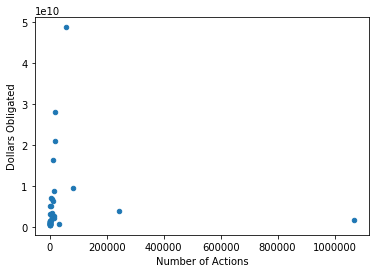

In [343]:
federal_overview.plot(kind = "scatter", x = "Number of Actions", y = "Dollars Obligated")


In [344]:
federal_overview.to_csv("Federal_Overview.csv")

In [303]:
#configuring map coordinates
gmaps.configure(api_key=g_key)
locations = federal_overview[["Lat", "Lon"]]
weights = federal_overview["Dollars Obligated"]

In [306]:
#create heatmap of federal spending df
fig = gmaps.figure()

dollars_spent = gmaps.heatmap_layer(locations, weights=weights, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

fig.add_layer(dollars_spent)

fig

Figure(layout=FigureLayout(height='420px'))

In [307]:
#adding text box with company details
info_box_template = """
<dl>
<dt>Company Name</dt><dd>{Business Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>State</dt><dd>{State}</dd>
<dt>Dollars Allocated</dt><dd>{Dollars Obligated}</dd>
</dl>
"""
company_info = [info_box_template.format(**row) for index, row in federal_overview.iterrows()]
locations = federal_overview[["Lat", "Lon"]]

info_layer = gmaps.symbol_layer(
    locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
    info_box_content= company_info
)

fig.add_layer(info_layer)
fig

Figure(layout=FigureLayout(height='420px'))